[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/statistics/outlier_detection.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Outlier detection

An [outlier](https://en.wikipedia.org/wiki/Outlier) is an observation (data point/sample) that is significantly different from the other observations in a dataset. Outliers can be caused by measurement errors, data entry errors, or they can be valid observations that are rare or extreme. Outliers can have a significant impact on statistical analyses and machine learning models, so it is important to identify and handle them appropriately.

In [1]:
# make sure the numpy package is installed
%pip install numpy --quiet
repo='data-science-course'
module='statistics'
# if running in colab, install the required packages and copy the necessary files
if get_ipython().__class__.__module__.startswith('google.colab'):
    import os
    if not os.path.exists(repo):
        !git clone --filter=blob:none --sparse https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
        !cd {repo} && git sparse-checkout init --cone && git sparse-checkout set {module}  2>/dev/null
    !cp --update {repo}/{module}/*.py . 2>/dev/null
    !mkdir -p img data
    !mv {repo}/{module}/img/* img/.  2>/dev/null
    !mv {repo}/{module}/data/* data/.  2>/dev/null

Note: you may need to restart the kernel to use updated packages.


## Dataset

We will use the Titanic dataset, which contains information about the passengers of the Titanic. The dataset is available at the seaborn library.

In [2]:
# get the titanic dataset from seaborn
import seaborn as sns
titanic_df = sns.load_dataset('titanic')
print(f"Shape of the dataset: {titanic_df.shape}.")
titanic_df.head(10)

Shape of the dataset: (891, 15).


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


## Percentiles

A percentile is the value below which a given percentage of observations fall. Pandas provides the `quantile` method to calculate the percentiles.

In [3]:
# calculate the 90th percentile for the 'age' column
print(f"90th percentile for the 'age' variable: {titanic_df['age'].quantile(0.9)}.")
print(f"10th percentile for the 'age' variable: {titanic_df['age'].quantile(0.1)}.")

90th percentile for the 'age' variable: 50.0.
10th percentile for the 'age' variable: 14.0.


## Interquartile range

The interquartile range (IQR) is the difference between the third and first quartiles ($Q_3 - Q_1$). It is a measure of dispersion that is robust to outliers.

In [4]:
 # show the first and third quartiles and the IQR for the 'age' column
q1 = titanic_df['age'].quantile(0.25)
q3 = titanic_df['age'].quantile(0.75)
iqr = q3 - q1
print(f"First quartile (Q1) for the 'age' variable: {q1}.")
print(f"Third quartile (Q3) for the 'age' variable: {q3}.")
print(f"Interquartile range (IQR) for the 'age' variable: {iqr}.")

First quartile (Q1) for the 'age' variable: 20.125.
Third quartile (Q3) for the 'age' variable: 38.0.
Interquartile range (IQR) for the 'age' variable: 17.875.


## Tukey's fences

IQR is also used to identify outliers with the Tukey's fences rule. The variable must be numerical, symmetrically distributed, and unimodal (i.e., one single peek value). The outliers are the values that are below $Q_1 - 1.5 \times IQR$ or above $Q_3 + 1.5 \times IQR$.

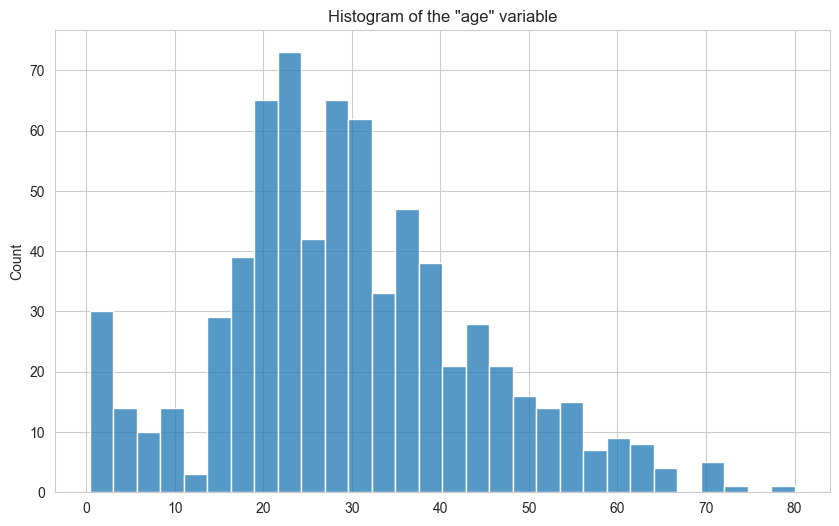

In [5]:
from matplotlib import pyplot as plt
# Let's see if the age variable is symmetrically distributed
# show histogram of the age variable
plt.figure(figsize=(10, 6))
sns.histplot(x=titanic_df['age'].values, bins=30)
plt.title('Histogram of the "age" variable')
plt.show()

The `age` variable is not symmetrically distributed, so we could not apply Tukey's fences. Let's apply it anyway to see the results.

In [6]:
import pandas as pd
# compute the outliers for the 'age' variable
def compute_outliers_tukey(column: pd.Series) -> pd.Series:
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return column[(column < lower_bound) | (column > upper_bound)]

age_outliers = compute_outliers_tukey(titanic_df['age'])
print(f"Number of outliers for the 'age' variable: {age_outliers.shape[0]} "
      f"out of {titanic_df.shape[0]}.")
print(f"Outliers:\n{age_outliers}.")

Number of outliers for the 'age' variable: 11 out of 891.
Outliers:
33     66.0
54     65.0
96     71.0
116    70.5
280    65.0
456    65.0
493    71.0
630    80.0
672    70.0
745    70.0
851    74.0
Name: age, dtype: float64.


## Modified Z-Score Method

The Modified Z-Score method (a.k.a., [Median Absolute Deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) (MAD) Outlier Detection) is another technique to identify outliers in a dataset. It is based on the median and the median absolute deviation (MAD) instead of the mean and standard deviation. It does not require data to be symmetrically distributed, although it still requires the data to be unimodal. Although data do not need to be symmetrically distributed, the Modified Z-Score method cannot be applied to strongly skewed distributions (e.g., asymmetric tail).

The Modified Z-Score is based on MAD, which is a measure of dispersion/variability more robust to outliers. It is defined as the median of the absolute deviations from the dataset's median:

$$
\text{MAD} = \text{median}(|x_i - \tilde{x}|)
$$

Then, the Modified Z-Score equation is defined as follows:

$$
M_i = \frac{0.6745 \times (x_i - \tilde{x})}{\text{MAD}}
$$

where:

- $M_i$ is the Modified Z-Score of observation $x_i$.
- $\tilde{x}$ is the median of the dataset.

The constant `0.6745` is used to make the MAD comparable to the standard deviation under the assumption of a normal distribution (since for a normal distribution, MAD ≈ 0.6745 × σ).


### Outlier identification rule for Modified Z-Score

Observations with an absolute Modified Z-Score greater than a certain threshold are considered outliers. A commonly used threshold is `3.5`:

$$
|M_i| > 3.5 \Rightarrow \text{Outlier}
$$

This threshold can be adjusted depending on how conservative the analysis should be.

In [7]:
def compute_outliers_modified_z_score(column: pd.Series) -> pd.Series:
    median = column.median()
    mad = (column - median).abs().median()
    modified_z_scores = 0.6745 * (column - median) / mad
    return column[modified_z_scores.abs() > 3.5]

age_outliers = compute_outliers_modified_z_score(titanic_df['age'])
print(f"Number of outliers for the 'age' variable: {age_outliers.shape[0]} "
      f"out of {titanic_df.shape[0]}.")
print(f"Outliers:\n{age_outliers}.")

Number of outliers for the 'age' variable: 1 out of 891.
Outliers:
630    80.0
Name: age, dtype: float64.


We can see how, in this case, the Tukey's fences method detected more outliers than the Modified Z-Score method, caused by the non-symmetrically distributed feature of the `age` variable.